# Solution to Tools - numpy - matplotlib - networkx - d3.js - detecting missing data and clustering

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee
import json
import pickle
%matplotlib inline

# 0. Function to generate data.

In [2]:
def generate_data():
    """
    Generate data.
    :return: connections and members_cluster
    """
    members_cluster = np.random.random_integers(0, 1, (N_MEMBERS, 3)).sum(axis=1) + 1  # Cluster number of members
    
    tmp = np.random.rand(N_REPLIES, N_MEMBERS)
    connections = np.zeros((N_REPLIES, N_MEMBERS))
    connections[tmp < OUT_OF_CLUSTER_P] = 1
    
    # Check
    print(connections.sum() / (N_REPLIES * N_MEMBERS))
    
    for i in range(N_REPLIES):
        cluster_i = members_cluster[i]
        for j in range(N_MEMBERS):
            cluster_j = members_cluster[j]
            if i == j:
                connections[i, j] = 0
            elif cluster_i == cluster_j:
                connections[i, j] = 1 if np.random.rand() < IN_CLUSTER_P else 0
    
    with open('data/connections.pkl','wb') as f:
         pickle.dump(connections, f)
    
    with open('data/member_cluster.pkl','wb') as f:
         pickle.dump(members_cluster, f)
    return connections, members_cluster

# 1. Generating data

In [3]:
GENERATE_DATA = True  # Turn on if you want fresh data
N_MEMBERS = 150
N_REPLIES = 100  # < N_MEMBERS!
OUT_OF_CLUSTER_P = 0.05  # Probability of connection out of cluster
IN_CLUSTER_P = 0.8  # Probability of connection in cluster


Generating data
0.05093333333333333


/Users/dumas/PycharmProjects/proj0016-big-data-project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  


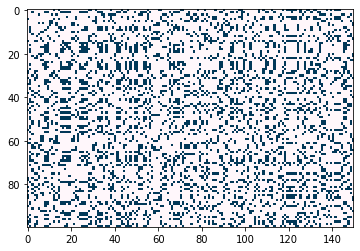

In [4]:
# Load data
if GENERATE_DATA:
    print("Generating data")
    connections, members_cluster = generate_data()
else:
    print("Loading data")
    with open('data/connections.pkl','rb') as f:
         connections = pickle.load(f)
    
    with open('data/member_cluster.pkl','rb') as f:
         members_cluster = pickle.load(f)

plt.imshow(connections, cmap="PuBu")

## 2 EXERCISE Plot the data sorted given cluster information

<div class="alert alert-success">
<ul>
  <li>connections is a N_REPLIES * N_MEMBERS adjacency matrix</li>
  <li>members_cluster contains the cluster information (ground_truth) </li>
  <li>Plot the matrix to highlight cluster information</li>
</ul>
</div>

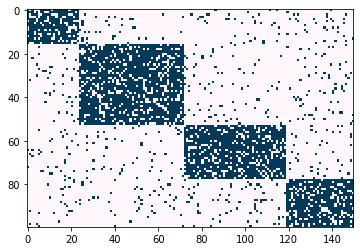

In [5]:
# Plotting the data sorted given cluster information

sorting_vector_replies = np.argsort(members_cluster[0:N_REPLIES])
sorting_vector_all = np.argsort(members_cluster)
sorted_connections = connections.copy()
sorted_connections[:, :] = sorted_connections[sorting_vector_replies, :]
sorted_connections[:, :] = sorted_connections[:, sorting_vector_all]
plt.imshow(sorted_connections, cmap="PuBu")

## 3 EXERCISE Create and plot the square adjacency matrix (without cluster information nor auto clustering)

<div class="alert alert-success">
<ul>
  <li>Store the matrix in an array S</li>
</ul>
</div>

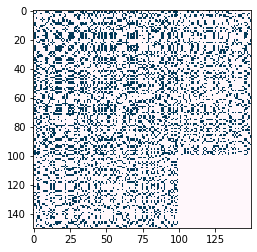

In [6]:
# Adjacency matrix representation
S = np.zeros((N_MEMBERS, N_MEMBERS))
S[0:N_REPLIES, 0:N_MEMBERS] = connections
S[0:N_MEMBERS, 0:N_REPLIES] += np.transpose(connections)
S[S > 1] = 1
plt.imshow(S, cmap="PuBu")

## 4 EXERCISE Use networkx to create a Graph G, and plot it

/Users/dumas/PycharmProjects/proj0016-big-data-project/venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


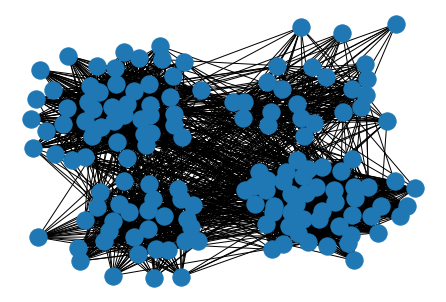

In [7]:
# Graph representation
G = nx.from_numpy_array(S)
nx.draw(G)

## 5 Below is an example usage of d3.js to create an interactive graph layout

In [8]:
# Dump to json for d3.js
nodes = [{'name': str(i), 'club': int(members_cluster[i])} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]}
         for u in G.edges()]
with open('data/graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links}, f, indent=4,)

In [9]:
%%html
<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [10]:
%%javascript
// We load the d3.js library from the Web.
require.config({
    paths:
        {d3: "http://d3js.org/d3.v3.min"}
});
require(["d3"], function (d3) {
    // The code in this block is executed when the
    // d3.js library has been loaded.

    // First, we specify the size of the canvas
    // containing the visualization (size of the
    // <div> element).
    var width = 1000, height = 1000;

    // We create a color scale.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(100)
        .size([width, height]);

    // In the <div> element, we create a <svg> graphic
    // that will contain our interactive visualization.
    var svg = d3.select("#d3-example").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-example").append("svg")
            .attr("width", width)
            .attr("height", height);
    }

    // We load the JSON file.
    d3.json("data/graph.json", function (error, graph) {
        // In this block, the file has been loaded
        // and the 'graph' object contains our graph.

        // We load the nodes and links in the
        // force-directed graph.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a <line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a <circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 10)  // radius
            .style("fill", function (d) {
                // The node color depends on the club.
                return color(d.club);
            })
            .call(force.drag);

        // The name of each node is the node number.
        node.append("title")
            .text(function (d) {
                return d.name;
            });

        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed
        // graph, at each time step.
        force.on("tick", function () {
            link.attr("x1", function (d) {
                return d.source.x
            })
                .attr("y1", function (d) {
                    return d.source.y
                })
                .attr("x2", function (d) {
                    return d.target.x
                })
                .attr("y2", function (d) {
                    return d.target.y
                });

            node.attr("cx", function (d) {
                return d.x
            })
                .attr("cy", function (d) {
                    return d.y
                });
        });
    });
});

<IPython.core.display.Javascript object>

## 6 EXERCISE Bonus : sort the adjacency matrix to highlight clusters, and plot it.

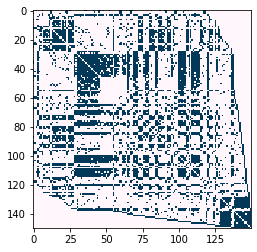

In [87]:
# Algorithm to sort rows and columns of adjacency matrix to  identify clusters.
graph = csr_matrix(S)  # Needed by the algo on the next line
sort_vector = reverse_cuthill_mckee(graph)  # Returns a permutation vector
S2 = S.copy()
S2[:, :] = S2[sort_vector, :]
S2[:, :] = S2[:, sort_vector]

plt.imshow(S2, cmap="PuBu")



